# Plotting

In [ ]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from alphatools import pp
from alphatools.pl import colors
from alphatools.pl.colors import show_rgba_color_list
from alphatools.pl.figure import create_figure, label_axes, save_figure
from alphatools.pl.plots import Plots

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic colors, palettes and color maps for AlphaTools

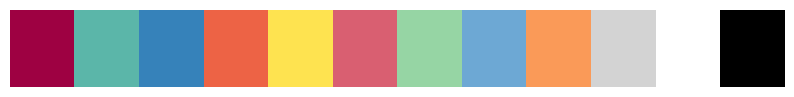

In [ ]:
# colors, derived from the basic palette
base_colors = [
    "red",
    "green",
    "blue",
    "orange",
    "yellow",
    "lightred",
    "lightgreen",
    "lightblue",
    "lightorange",
    "grey",
    "white",
    "black",
]
show_rgba_color_list([colors.BaseColors.get(color) for color in base_colors])

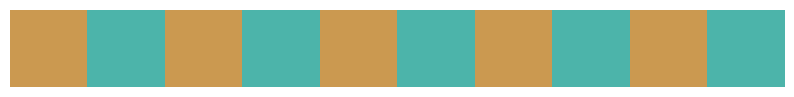

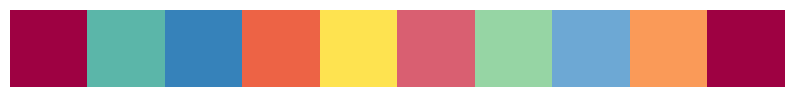

In [ ]:
# color palettes
palettes = ["binary", "qualitative"]
for palette in palettes:
    show_rgba_color_list(colors.BasePalettes.get(palette))

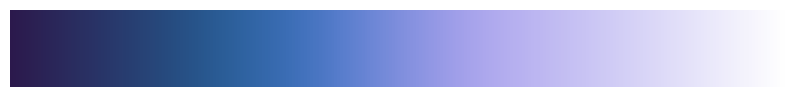

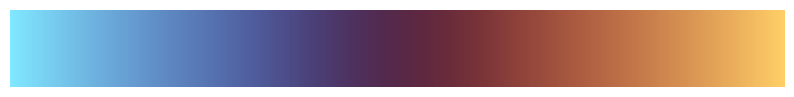

In [ ]:
# colormaps
maps = ["sequential", "diverging"]
for cmap in maps:
    show_rgba_color_list(list(colors.BaseColormaps.get(cmap)(np.arange(0, 1, 0.001))))

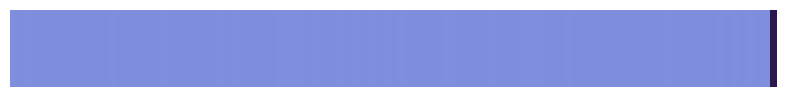

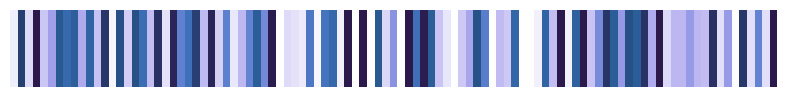

In [ ]:
test_data = [*list(np.random.rand(100)), -100, 100]

# map colormaps to numerical values without capping
mapped_colors = colors.MappedColormaps("sequential").fit_transform(test_data)
show_rgba_color_list(mapped_colors)

# map colormaps to numerical values with capping
mapped_colors = colors.MappedColormaps("sequential", (5, 95)).fit_transform(test_data)
show_rgba_color_list(mapped_colors)

## Demonstrate figure.py submodule style & label handling

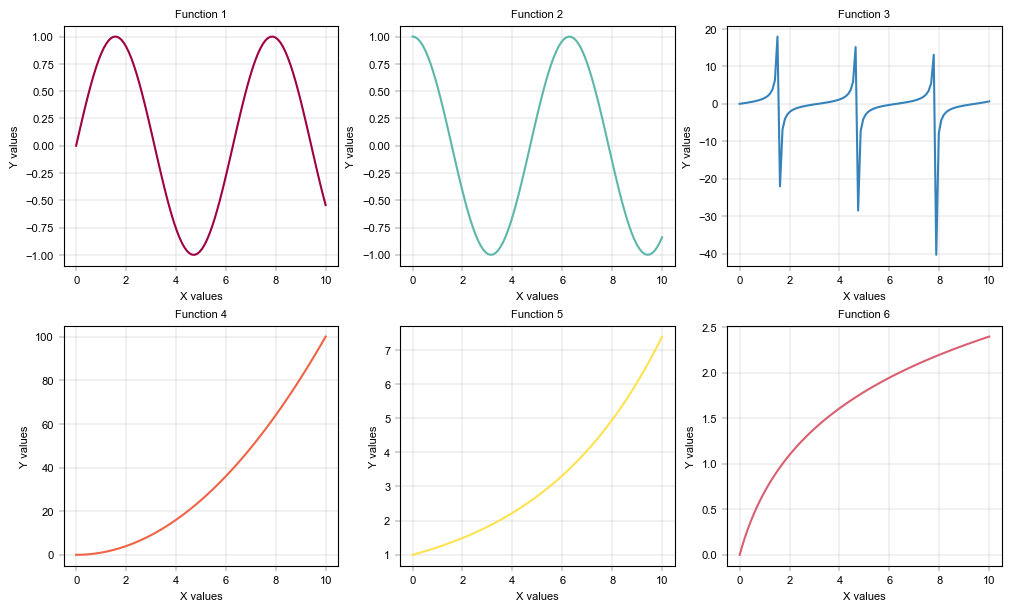

In [ ]:
# Create a 2x3 grid of subplots in an AxisManager
fig, axm = create_figure(
    nrows=2,
    ncols=3,
    figsize=(10, 6),
    # figure_padding=3
)

# Example dataset
x = np.linspace(0, 10, 100)
y_funcs = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: np.tan(x),
    lambda x: x**2,
    lambda x: np.exp(x / 5),
    lambda x: np.log(x + 1),
]

# Get qualitative palette
palette = colors.BasePalettes.get("qualitative", len(y_funcs))

# Iterate through all axes using next() and plot different functions
try:
    for i, func in enumerate(y_funcs):
        ax = axm.next()
        ax.plot(x, func(x), color=palette[i])
        label_axes(ax, xlabel="X values", ylabel="Y values", title=f"Function {i + 1}")
except StopIteration:
    pass

plt.show()

# Save the figure
save_figure(
    fig=fig,
    filename="example_figure.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Basic histogram

In [ ]:
example_df = pd.DataFrame(
    {
        "values": np.concatenate([np.random.normal(i, size=200) + np.random.normal(i) for i in range(3)]),
        "values2": np.concatenate([np.random.normal(i, size=200) + np.random.normal(i) for i in range(3)]),
        "levels": [i for i in range(3) for _ in range(200)],
        "levels2": np.arange(0, 600),
    }
)

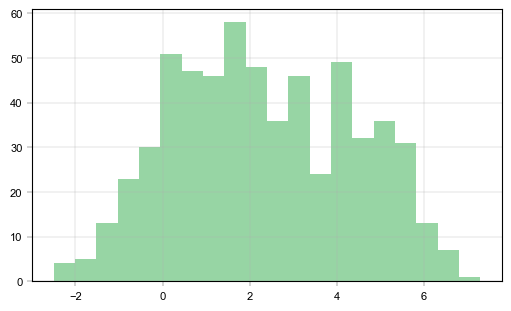

In [ ]:
# with one color
fig, axm = create_figure(figsize=(5, 3))

# Use the AxisManager
ax = axm.next()
Plots.histogram(
    data=example_df,
    value_column="values",
    bins=20,
    color="lightgreen",
    ax=ax,
)

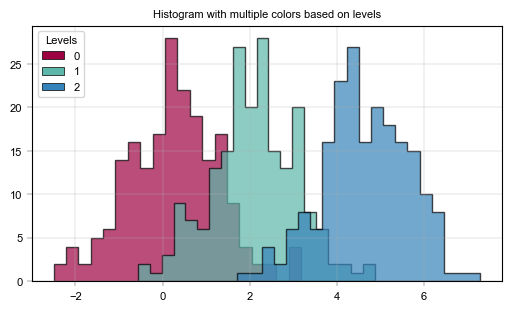

In [ ]:
# with multiple colors based on levels
fig, axm = create_figure(figsize=(5, 3))

# Apply the AxisManager
ax = axm.next()
palette = colors.BasePalettes.get("qualitative", example_df["levels"].nunique())
Plots.histogram(
    data=example_df,
    value_column="values",
    color_map_column="levels",
    palette=palette,
    bins=20,
    color="blue",
    ax=ax,
    legend="auto",
    hist_kwargs={"alpha": 0.7, "histtype": "stepfilled", "edgecolor": "k"},
    legend_kwargs={"title": "Levels", "loc": "upper left"},
)
label_axes(ax, title="Histogram with multiple colors based on levels")
plt.show()

# Save the figure
save_figure(
    fig=fig,
    filename="example_histogram.png",
    output_dir="./example_outputs",
    dpi=300,
    transparent=False,
)

## Rank plot of protein median intensities across all samples

In [ ]:
# read an example proteomics data
# load protein groups into an AnnData object with index & columns as obs & var
data_path = "./example_data/HeLa_QC_data.pkl"
adata = pp.load_diann_pg_matrix(data_path)

# Add sample metadata
sample_metadata = pd.read_csv("./example_data/HeLa_QC_sample_metadata.csv", index_col=0)
adata = pp.add_metadata(adata, sample_metadata, axis=0)

# Add feature metadata
feature_metadata = pd.read_csv("./example_data/HeLa_QC_feature_metadata.csv", index_col=0)
adata = pp.add_metadata(adata, feature_metadata, axis=1)

Add a layer called 'intensity' to store raw data 

In [ ]:
adata.layers["intensity"] = adata.X.copy()

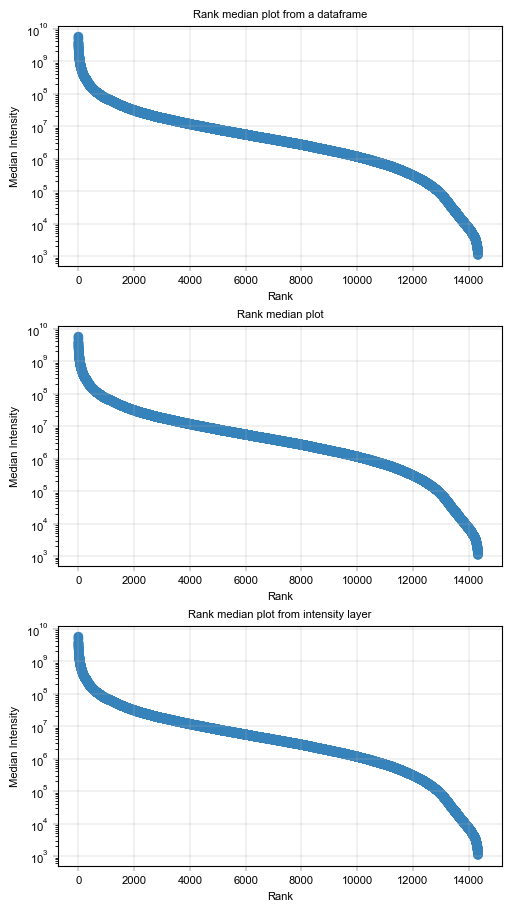

In [ ]:
fig, axm = create_figure(3, 1, figsize=(5, 9))

# Create median rank plot from a dataframe
ax = axm.next()
data_df = adata.to_df()
Plots.rank_median_plot(data_df, ax=ax)
label_axes(ax, title="Rank median plot from a dataframe")

# figure using the default settings for AnnData
ax = axm.next()
Plots.rank_median_plot(adata, ax=ax)
label_axes(ax, title="Rank median plot")

# figure with a non-default layer
ax = axm.next()
Plots.rank_median_plot(adata, layer="intensity", ax=ax)
label_axes(ax, title="Rank median plot from intensity layer")

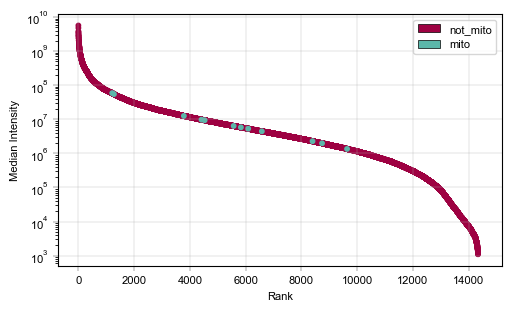

In [ ]:
# create a column for mitochondrial proteins tp color code the rank plot
mt_mask = adata.var["Genes"].str.startswith("MT-")
adata.var["Mito_prot"] = "not_mito"
adata.var.loc[mt_mask, "Mito_prot"] = "mito"

fig, axs = create_figure(figsize=(5, 3))
ax = axs.next()
Plots.rank_median_plot(adata, ax=ax, color_map_column="Mito_prot", scatter_kwargs={"s": 10}, legend="auto")

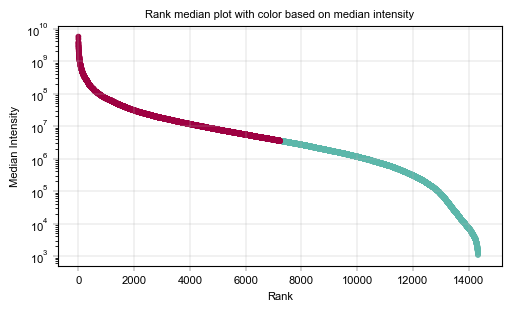

In [ ]:
# get median intensity of all proteins and color by above and below median of medians
medians = np.nanmedian(adata.X, axis=0)
median_median = np.nanmedian(medians)
adata.var["Median_intensity"] = medians

med_mask = adata.var["Median_intensity"] > median_median
adata.var["Above_median"] = "blue"
adata.var.loc[med_mask, "Above_median"] = "red"

fig, axs = create_figure(figsize=(5, 3))
ax = axs.next()
Plots.rank_median_plot(adata, ax=ax, color_map_column="Above_median", scatter_kwargs={"s": 10})

label_axes(ax, title="Rank median plot with color based on median intensity")